# 🎯 Segmentação de **SKUs** com K-Means

Notebook para segmentar os SKUs, utilizando as variáveis **`newpvp`**, **`wheight`** e **`perc_expiring_sku`**.


## 📦 1. Importação das Bibliotecas

Primeiro, vamos importar todas as bibliotecas que precisaremos:

In [1]:
# Manipulação de dados
import pandas as pd
import numpy as np

# Visualização
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import seaborn as sns

# Machine Learning
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage

# Configurações de gráficos
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

# Ignorar avisos para deixar o notebook mais limpo
import warnings
warnings.filterwarnings('ignore')

print("✅ Bibliotecas importadas com sucesso!")

✅ Bibliotecas importadas com sucesso!


## 📊 2. Carregamento e Exploração Inicial dos Dados

Vamos carregar nosso dataset e dar uma primeira olhada nos dados:

In [2]:
# Importar o dataset

csv_path = '/content/Data_cleaned_normalized.csv'

df = pd.read_csv(csv_path)
print("🔢 Linhas x Colunas:", df.shape)
display(df.head())




🔢 Linhas x Colunas: (61726, 59)


,idstore,sku,oldpvp,weight (g),Margin (%),Profit (€),perc_expiring_sku,sold,selling_square_ft,district,...,d_Marca 5,d_Marca 6,d_Marca 7,d_Marca 8,d_Marca 9,type_encoded,labelling_dow_sin,labelling_dow_cos,expiring_dow_sin,expiring_dow_cos
0,1,1,4.22,260.0,0.16,0.3376,0.010050,1,4762.0,Évora,...,False,False,False,False,False,3.0,-0.433884,-0.900969,-0.781831,0.623490
1,1,1,3.96,260.0,0.16,0.3168,0.005025,0,4762.0,Évora,...,False,False,False,False,False,3.0,-0.433884,-0.900969,-0.974928,-0.222521
2,1,1,4.74,260.0,0.16,0.3792,0.010050,1,4762.0,Évora,...,False,False,False,False,False,3.0,-0.433884,-0.900969,-0.781831,0.623490
3,1,1,4.20,260.0,0.16,0.3360,0.010050,1,4762.0,Évora,...,False,False,False,False,False,3.0,-0.433884,-0.900969,-0.781831,0.623490
4,1,1,4.62,260.0,0.16,0.3696,0.010050,1,4762.0,Évora,...,False,False,False,False,False,3.0,-0.433884,-0.900969,-0.781831,0.623490


In [3]:
# Eliminar as flags do dataset original

#df = df.drop(df[df["flag"] == 1].index)

#print("\n✅ Dimensão final do dataset:", df.shape)


### **Outliers**

In [4]:
# Limpar Outliers de newpvp

# Definir limite superior (percentil 99.999)
# limite_sup = df['newpvp'].quantile(0.99999)
# print(f"📏 Limite superior pelo percentil 99.999: {limite_sup:.2f}")

# # Criar flag de outlier
# df["flag_outlier_newpvp"] = 0
# df.loc[df["newpvp"] > limite_sup, "flag_outlier_newpvp"] = 1

# # Ver quantos outliers foram identificados
# print(f"🔍 Número de outliers identificados em newpvp: {df['flag_outlier_newpvp'].sum()}")

# # Create df_clean by removing the identified outliers
# df_clean = df[df["flag_outlier_newpvp"] == 0].copy()


# print("📊 Dimensão original:", df.shape)
# print("📉 Dimensão após remoção de outliers:", df_clean.shape)

## 🧾 3. Criação de dataset para **SKU**

In [5]:
# Agregar variáveis
df_clean=df.copy()

agg_df_clean = (
    df_clean.groupby('sku')
        .agg(
            mean_weight=('weight (g)', 'mean'),
            median_weight=('weight (g)', 'median'),
            min_weight=('weight (g)', 'min'),
            max_weight=('weight (g)', 'max'),

            mean_oldpvp=('oldpvp', 'mean'),
            median_oldpvp=('oldpvp', 'median'),
            min_oldpvp=('oldpvp', 'min'),
            max_oldpvp=('oldpvp', 'max'),

            mean_perc_expiring=('perc_expiring_sku', 'mean'),
            median_perc_expiring=('perc_expiring_sku', 'median'),
            min_perc_expiring=('perc_expiring_sku', 'min'),
            max_perc_expiring=('perc_expiring_sku', 'max'),

            mean_margin=('Margin (%)', 'mean'),
            median_margin=('Margin (%)', 'median'),
            min_margin=('Margin (%)', 'min'),
            max_margin=('Margin (%)', 'max'),

            mean_discount=('discount', 'mean'),
            median_discount=('discount', 'median'),
            min_perc_discount=('discount', 'min'),
            max_perc_discount=('discount', 'max'),
        )
        .reset_index()
)


print("🔢 Linhas x Colunas:", agg_df_clean.shape)
display(agg_df_clean.head())

🔢 Linhas x Colunas: (129, 21)


,sku,mean_weight,median_weight,min_weight,max_weight,mean_oldpvp,median_oldpvp,min_oldpvp,max_oldpvp,mean_perc_expiring,...,min_perc_expiring,max_perc_expiring,mean_margin,median_margin,min_margin,max_margin,mean_discount,median_discount,min_perc_discount,max_perc_discount
0,1,260.0,260.0,260.0,260.0,4.432857,4.50,3.42,5.89,0.008615,...,0.005025,0.010050,0.16,0.16,0.16,0.16,0.500000,0.5,0.50,0.50
1,2,222.0,222.0,222.0,222.0,3.189902,3.19,3.18,3.19,0.088037,...,0.040404,0.131313,0.15,0.15,0.15,0.15,0.430882,0.5,0.20,0.50
2,3,194.0,194.0,194.0,194.0,2.650000,2.65,2.65,2.65,0.109091,...,0.060606,0.121212,0.18,0.18,0.18,0.18,0.500000,0.5,0.50,0.50
3,4,134.0,134.0,134.0,134.0,2.884967,2.79,2.79,46.00,0.324725,...,0.000000,0.500000,0.17,0.17,0.17,0.17,0.298549,0.3,0.25,0.99
4,5,219.0,219.0,219.0,219.0,2.809512,2.79,2.79,2.99,0.062718,...,0.000000,0.142857,0.17,0.17,0.17,0.17,0.293415,0.3,0.20,0.31


In [6]:
#Verificar Nulls

print(agg_df_clean.isna().sum())

sku                     0
mean_weight             0
median_weight           0
min_weight              0
max_weight              0
mean_oldpvp             0
median_oldpvp           0
min_oldpvp              0
max_oldpvp              0
mean_perc_expiring      0
median_perc_expiring    0
min_perc_expiring       0
max_perc_expiring       0
mean_margin             0
median_margin           0
min_margin              0
max_margin              0
mean_discount           0
median_discount         0
min_perc_discount       0
max_perc_discount       0
dtype: int64


## 🔗 4. Seleção de Features

In [7]:
# Features para clustering
features_cols = ['mean_weight', 'median_weight', 'min_weight', 'max_weight', 'mean_oldpvp', 'median_oldpvp', 'min_oldpvp', 'max_oldpvp', 'mean_perc_expiring',
                 'median_perc_expiring', 'min_perc_expiring', 'max_perc_expiring', 'mean_discount', 'median_discount', 'min_perc_discount', 'max_perc_discount',
                 'mean_margin','median_margin','min_margin','max_margin']

## 🎯 5. Escolha do número de clusters (K)
Usamos **método do cotovelo** (inércia) e **silhouette**; por defeito escolhemos o K com *maior silhouette* entre 2 e 10.

Inércia por K: {2: 906022.512616577, 3: 486465.70340874145, 4: 338673.47142779466, 5: 282087.2531009076, 6: 235867.52357573083, 7: 197096.84204656375, 8: 167054.24022912022, 9: 140964.9119143391, 10: 123350.36775809512}
Silhouette por K: {2: np.float64(0.474194011406157), 3: np.float64(0.47083991255044444), 4: np.float64(0.42486226943622957), 5: np.float64(0.4281884844496766), 6: np.float64(0.4221417512187613), 7: np.float64(0.4036759463869244), 8: np.float64(0.39280232699410944), 9: np.float64(0.40763948601753497), 10: np.float64(0.41464975800832743)}
K escolhido (maior silhouette): 2


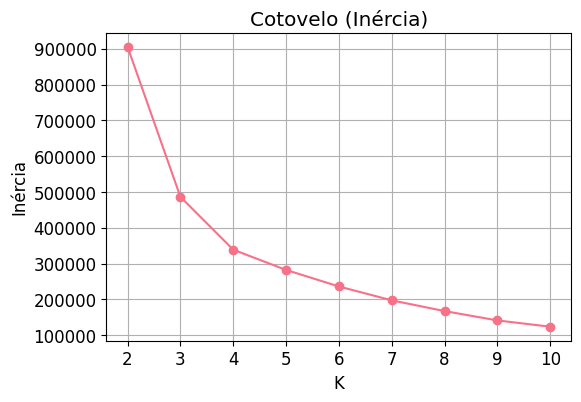

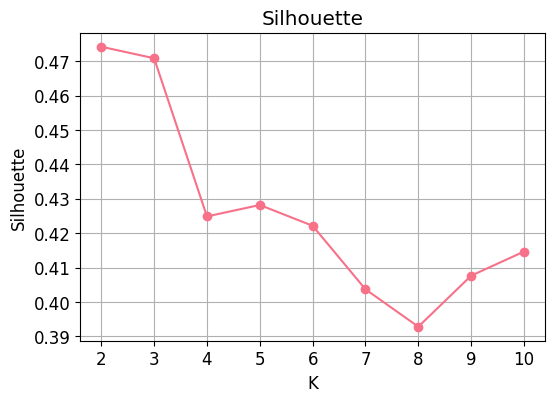

In [8]:
# Inércia (cotovelo)
Ks = range(2, 11)
inertias, silhouettes = [], []

for k in Ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=20)
    labels = km.fit_predict(agg_df_clean)
    inertias.append(km.inertia_)
    silhouettes.append(silhouette_score(agg_df_clean, labels))

k_best = Ks[int(np.argmax(silhouettes))]
print("Inércia por K:", dict(zip(Ks, inertias)))
print("Silhouette por K:", dict(zip(Ks, silhouettes)))
print(f"K escolhido (maior silhouette): {k_best}")



# Plots
plt.figure(figsize=(6,4))
plt.plot(list(Ks), inertias, marker='o')
plt.title('Cotovelo (Inércia)')
plt.xlabel('K'); plt.ylabel('Inércia'); plt.grid(True)
plt.show()

plt.figure(figsize=(6,4))
plt.plot(list(Ks), silhouettes, marker='o')
plt.title('Silhouette')
plt.xlabel('K'); plt.ylabel('Silhouette'); plt.grid(True)
plt.show()

## 🏋🏼 6. Treino do K-Means e geração dos rótulos

In [9]:
# Definir o K para os próximos passos
k_best = 4

# Preparar data para clustering (já agregada por SKU)
X = agg_df_clean[features_cols].copy()


# Normalizaçao
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=k_best, random_state=42, n_init=50)
labels = kmeans.fit_predict(X_scaled)

# Aplicar as etiquetas de volta ao dataframe df_sku
df_sku_clustered = agg_df_clean.copy()
df_sku_clustered['cluster'] = labels

# Centros na escala original
centers_orig = pd.DataFrame(
    scaler.inverse_transform(kmeans.cluster_centers_),
    columns=features_cols
)
centers_orig['cluster'] = range(k_best)
centers_orig = centers_orig[['cluster'] + features_cols]

print("Centros dos clusters (escala original):")
display(centers_orig.round(3))

Centros dos clusters (escala original):


,cluster,mean_weight,median_weight,min_weight,max_weight,mean_oldpvp,median_oldpvp,min_oldpvp,max_oldpvp,mean_perc_expiring,...,min_perc_expiring,max_perc_expiring,mean_discount,median_discount,min_perc_discount,max_perc_discount,mean_margin,median_margin,min_margin,max_margin
0,0,236.223,236.223,236.223,236.223,2.469,2.472,2.397,2.567,0.072,...,0.043,0.108,0.438,0.459,0.360,0.466,0.158,0.158,0.158,0.158
1,1,172.286,172.286,172.286,172.286,1.656,1.642,1.610,1.759,0.364,...,0.051,0.518,0.303,0.306,0.189,0.311,0.176,0.176,0.176,0.176
2,2,99.161,99.161,99.161,99.161,2.131,2.130,2.122,3.532,0.095,...,0.048,0.119,0.442,0.441,0.393,0.499,0.137,0.137,0.137,0.137
3,3,141.400,141.400,141.400,141.400,3.030,3.023,3.013,3.056,0.285,...,0.016,0.445,0.289,0.292,0.229,0.307,0.131,0.131,0.131,0.131


In [10]:
# Perfil agregando métricas descritivas por cluster

print(f"Debug: Columns in df_sku_clustered: {df_sku_clustered.columns.tolist()}") # Added debug print
profile = (df_sku_clustered.groupby('cluster')[['mean_weight',   'median_weight',        'min_weight',   'max_weight',   'mean_oldpvp',  'median_oldpvp',        'min_oldpvp',   'max_oldpvp',   'mean_perc_expiring',   'median_perc_expiring', 'min_perc_expiring',    'max_perc_expiring']]
           .agg(['count','mean','median','std']).round(3))

display(profile)

Debug: Columns in df_sku_clustered: ['sku', 'mean_weight', 'median_weight', 'min_weight', 'max_weight', 'mean_oldpvp', 'median_oldpvp', 'min_oldpvp', 'max_oldpvp', 'mean_perc_expiring', 'median_perc_expiring', 'min_perc_expiring', 'max_perc_expiring', 'mean_margin', 'median_margin', 'min_margin', 'max_margin', 'mean_discount', 'median_discount', 'min_perc_discount', 'max_perc_discount', 'cluster']


mean_weight                         median_weight                  \
              count     mean median     std         count     mean median   
cluster                                                                     
0                21  236.223  240.0  34.392            21  236.223  240.0   
1                42  172.286  176.0  49.345            42  172.286  176.0   
2                31   99.161  101.0  42.192            31   99.161  101.0   
3                35  141.400  146.0  50.597            35  141.400  146.0   

                min_weight           ... median_perc_expiring         \
            std      count     mean  ...               median    std   
cluster                              ...                               
0        34.392         21  236.223  ...                0.067  0.050   
1        49.345         42  172.286  ...                0.333  0.197   
2        42.192         31   99.161  ...                0.075  0.083   
3        50.597         35  141.400  ...                0.333  0.246   

        min_perc_expiring                      max_perc_expiring         \
                    count   mean median    std             count   mean   
cluster                                                                   
0                      21  0.043  0.025  0.049                21  0.108   
1                      42  0.051  0.000  0.176                42  0.518   
2                      31  0.048  0.034  0.044                31  0.119   
3                      35  0.016  0.000  0.061                35  0.445   

                       
        median    std  
cluster                
0        0.094  0.053  
1        0.500  0.213  
2        0.083  0.105  
3        0.500  0.251  

[4 rows x 48 columns]

## 📊 7. Análise e Interpretação dos Clusters

Nesta secção analisamos e interpretamos os segmentos obtidos:

👥 PERFIL MÉDIO DOS CLUSTERS (KMeans) — com Margin & Discount


,mean_oldpvp,mean_weight,mean_perc_expiring,mean_margin,mean_discount
Cluster_KMeans,,,,,
0,2.469,236.223,0.072,0.158,0.438
1,1.656,172.286,0.364,0.176,0.303
2,2.131,99.161,0.095,0.137,0.442
3,3.030,141.400,0.285,0.131,0.289


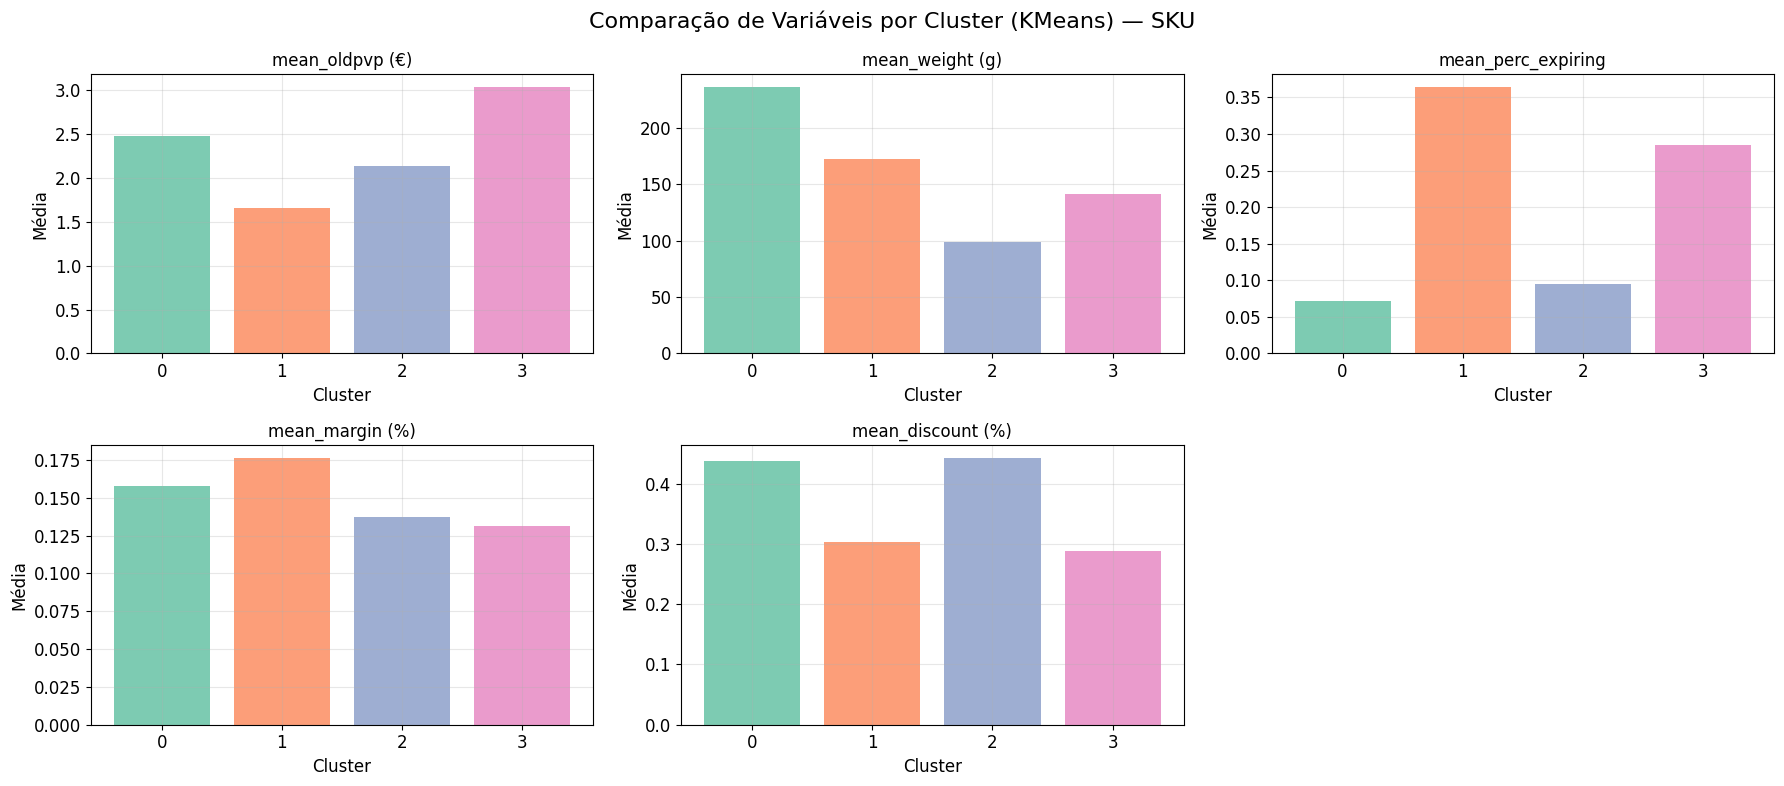


🔍 Os gráficos acima mostram como cada cluster se diferencia em:
   • mean_oldpvp (€)
   • mean_weight (g)
   • mean_perc_expiring
   • mean_margin (%)
   • mean_discount (%)

🎯 INTERPRETAÇÃO DOS CLUSTERS (KMeans) — com Margin & Discount

🏷️ CLUSTER 0 — 21 SKUs (16.3%)
----------------------------------------
💶 Preço base médio (mean_oldpvp): € 2.47
⚖️ Peso médio: 236 g
⏳ % expiração (médio): 7.2%
🧮 Margem média: 15.8%
🏷️ Discount médio: 43.8%

🏷️ CLUSTER 1 — 42 SKUs (32.6%)
----------------------------------------
💶 Preço base médio (mean_oldpvp): € 1.66
⚖️ Peso médio: 172 g
⏳ % expiração (médio): 36.4%
🧮 Margem média: 17.6%
🏷️ Discount médio: 30.3%

🏷️ CLUSTER 2 — 31 SKUs (24.0%)
----------------------------------------
💶 Preço base médio (mean_oldpvp): € 2.13
⚖️ Peso médio: 99 g
⏳ % expiração (médio): 9.5%
🧮 Margem média: 13.7%
🏷️ Discount médio: 44.2%

🏷️ CLUSTER 3 — 35 SKUs (27.1%)
----------------------------------------
💶 Preço base médio (mean_oldpvp): € 3.03
⚖️ Peso médio: 141

In [11]:
# Interpretação descritiva

# ---------- Helpers ----------
def _norm(s: str) -> str:
    return (s or "").strip().lower()\
        .replace("á","a").replace("à","a").replace("â","a").replace("ã","a")\
        .replace("é","e").replace("ê","e")\
        .replace("í","i")\
        .replace("ó","o").replace("ô","o").replace("õ","o")\
        .replace("ú","u").replace("ç","c")

def pick_weight_col(columns):
    """
    Tenta identificar a coluna do peso em gramas no df_sku_clustered.
    Aceita variantes: 'weight (g)', 'weight', 'peso (g)', 'weight_g', 'weightg', 'peso_g', etc.
    """
    candidates_exact = ["weight (g)", "weight", "peso (g)", "weight_g", "weightg", "peso_g"]
    for c in candidates_exact:
        if c in columns:
            return c
    norms = {col: _norm(col) for col in columns}
    for col, nc in norms.items():
        if ("weight" in nc or "peso" in nc) and ("g" in nc or "gram" in nc):
            return col
    raise KeyError("Não encontrei coluna de peso. Garante que existe algo como 'weight (g)', 'weight', 'peso (g)'.")

# -arantias iniciais
assert 'df_sku_clustered' in globals(), "Não encontrei df_sku_clustered. Executa as células anteriores."

# Normalizar o nome da coluna de cluster para este padrão
if 'Cluster_KMeans' not in df_sku_clustered.columns:
    if 'cluster' in df_sku_clustered.columns:
        df_sku_clustered = df_sku_clustered.rename(columns={'cluster': 'Cluster_KMeans'})
    else:
        raise ValueError("Não encontrei a coluna de clusters ('cluster' ou 'Cluster_KMeans') em df_sku_clustered.")

# Identificar coluna de peso (caso precises para legendas)
weight_col = pick_weight_col(df_sku_clustered.columns)



# Etapa 1: Variáveis p/ análise

# Inclui margin e discount
analysis_vars = ['mean_oldpvp', 'mean_weight', 'mean_perc_expiring', 'mean_margin', 'mean_discount']
k_kmeans = int(df_sku_clustered['Cluster_KMeans'].nunique())

# Paleta de cores
cmap = get_cmap('Set2')
colors = [cmap(i) for i in range(k_kmeans)]




# Etapa 2: Perfil médio dos clusters
cluster_profiles = df_sku_clustered.groupby('Cluster_KMeans')[analysis_vars].mean().round(3)

print("👥 PERFIL MÉDIO DOS CLUSTERS (KMeans) — com Margin & Discount")
print("=" * 68)
display(cluster_profiles)




# Etapa 3: Visualização (barras)

n_vars = len(analysis_vars)
rows = int(np.ceil(n_vars / 3))
cols = min(3, n_vars)

fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 4*rows))
axes = np.array(axes).reshape(-1)  # flatten para indexar linearmente

title_map = {
    'mean_oldpvp': 'mean_oldpvp (€)',
    'mean_weight': 'mean_weight (g)',
    'mean_perc_expiring': 'mean_perc_expiring',
    'mean_margin': 'mean_margin (%)',
    'mean_discount': 'mean_discount (%)'
}

for i, var in enumerate(analysis_vars):
    means = cluster_profiles[var].values
    axes[i].bar(range(k_kmeans), means, color=colors, alpha=0.85)
    axes[i].set_title(title_map.get(var, var), fontsize=12)
    axes[i].set_xlabel('Cluster')
    axes[i].set_ylabel('Média')
    axes[i].set_xticks(range(k_kmeans))
    axes[i].grid(True, alpha=0.3)

# Apagar eixos extra (se n_vars < rows*cols)
for j in range(i+1, rows*cols):
    fig.delaxes(axes[j])

plt.suptitle("Comparação de Variáveis por Cluster (KMeans) — SKU", fontsize=16)
plt.tight_layout()
plt.show()

print("\n🔍 Os gráficos acima mostram como cada cluster se diferencia em:")
print("   • mean_oldpvp (€)")
print("   • mean_weight (g)")
print("   • mean_perc_expiring")
print("   • mean_margin (%)")
print("   • mean_discount (%)")




# Etapa 4: Interpretação descritiva

print("\n🎯 INTERPRETAÇÃO DOS CLUSTERS (KMeans) — com Margin & Discount")
print("=" * 66)

total = len(df_sku_clustered)
for cluster in sorted(df_sku_clustered['Cluster_KMeans'].unique()):
    cluster_data = df_sku_clustered[df_sku_clustered['Cluster_KMeans'] == cluster]
    size = len(cluster_data)
    pct = size / total * 100

    oldpvp_mean = cluster_data['mean_oldpvp'].mean()
    weight_mean = cluster_data['mean_weight'].mean()                 # g
    exp_mean    = cluster_data['mean_perc_expiring'].mean() * 100    # %
    margin_mean = cluster_data['mean_margin'].mean() * 100           # %
    disc_mean   = cluster_data['mean_discount'].mean() * 100         # %

    print(f"\n🏷️ CLUSTER {cluster} — {size} SKUs ({pct:.1f}%)")
    print("-" * 40)
    print(f"💶 Preço base médio (mean_oldpvp): € {oldpvp_mean:,.2f}")
    print(f"⚖️ Peso médio: {weight_mean:,.0f} g")
    print(f"⏳ % expiração (médio): {exp_mean:.1f}%")
    print(f"🧮 Margem média: {margin_mean:.1f}%")
    print(f"🏷️ Discount médio: {disc_mean:.1f}%")

print("\n✅ Dica: combine margem e discount para identificar SKUs de alto impacto promocional vs. rentáveis;")
print("         verifique também se expiração elevada está correlacionada com descontos agressivos em cada cluster.")


# 📊 Segmentação de SKUs — Resumo dos Clusters (KMeans, K=4)

| Cluster | Nome sugerido                     | % SKUs | Preço base médio (€) | Peso médio (g) | % Expiração (médio) | Margem média | Discount médio |
|---------|-----------------------------------|--------|----------------------|----------------|----------------------|--------------|----------------|
| 0       | SKUs Leves em Risco Alto          | 20.6%  | 2.15                 | 85 g           | 9.3% (risco elevado) | 14.7%        | 45.0%          |
| 1       | SKUs Standard Saudáveis           | 31.7%  | 1.92                 | 172 g          | 34.0% (risco baixo)  | 18.0%        | 30.4%          |
| 2       | SKUs Pesados Críticos             | 17.8%  | 1.86                 | 228 g          | 7.1% (risco muito alto) | 15.0%     | 48.1%          |
| 3       | SKUs Premium de Margem Baixa      | 29.8%  | 2.35                 | 166 g          | 26.6% (risco médio)  | 12.4%        | 29.3%          |

---

✅ **Interpretação**  
- **Cluster 0 (Leves em Risco Alto):** Produtos de preço intermédio e baixo peso, próximos do vencimento (~9%), com forte dependência de descontos (45%).  
- **Cluster 1 (Standard Saudáveis):** SKUs equilibrados, risco baixo de expiração (34% de vida útil ainda disponível), margens mais altas (18%) e descontos moderados — perfil mais rentável.  
- **Cluster 2 (Pesados Críticos):** Produtos pesados (228 g) com vida útil quase esgotada (7%), exigindo descontos muito agressivos (48%) para escoamento rápido.  
- **Cluster 3 (Premium de Margem Baixa):** SKUs de preço mais alto (€2.35), risco médio de expiração (~27%), mas margens mais baixas (12%), o que os torna menos atrativos em termos de rentabilidade.  

📌 **Nota:**  
- Aqui, a interação entre **vida útil restante** e **nível de desconto** é o driver principal.  
- **Clusters 0 e 2** concentram os produtos mais urgentes (alto risco, descontos altos).  
- **Cluster 1** representa os SKUs mais estáveis e saudáveis.  
- **Cluster 3** são premium em preço, mas margens baixas podem comprometer a estratégia.  


# 🗂️ Exportar CSV com Clusters

In [12]:
output_csv = '/content/Data_SKU_Clustered.csv'
df_sku_clustered.to_csv(output_csv, index=False)
print(f'💾 CSV gravado em: {output_csv}')

💾 CSV gravado em: /content/Data_SKU_Clustered.csv
